## Imports and Config

In [3]:
import sys
import ntpath
import h5py

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score)
from sklearn.preprocessing import (LabelEncoder, 
                                   MinMaxScaler, 
                                   StandardScaler)
                                   
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import (ModelCheckpoint, 
                                        EarlyStopping, 
                                        LearningRateScheduler)

# Visualization
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
# Increase default plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
# Enhance svg plots appearance
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Pandas       : 1.2.0
Tensorflow   : 2.5.0
Keras        : 2.5.0


In [80]:
RANDOM_SEED = 42

WORK_DIR = ''

## Prepare Data

### Dataset Pathways

In [81]:
DATA_PATH = 'dataset/'

SOURCE_FILENAME = 'source_df.h5'
FEATURES_FILENAME = 'features_df.h5'
MELSPECS_FILENAME = 'melspecs.h5'

### Load Files

In [82]:
# Load SOURCE dataframe
source_df = pd.read_hdf(DATA_PATH + SOURCE_FILENAME)

source_df['accent'].value_counts()

us             171217
england         46836
indian          33637
australia       24230
canada          21077
scotland         6204
ireland          3938
newzealand       3378
african          3188
philippines      2295
singapore        2001
hongkong         1256
Name: accent, dtype: int64

In [83]:
ACCENTS_LIST = ['us', 
                'canada', 
                'england',#, 
                # 'scotland', 
                # 'ireland', 
                # 'african', 
                'indian',# 'hongkong', 
                'australia', #'newzealand', 
#                 'singapore', 'philippines'
               ]


ACCENT_THRESH = 20000  # threshold of max number of samples for each accent
NUM_CLASSES = len(ACCENTS_LIST)

In [84]:
source_df.groupby('accent')['gender'].value_counts()

accent       gender
african      male        2741
             female       437
australia    male       13083
             other       8194
             female      2901
canada       male       15860
             female      4665
             other        287
england      male       35538
             female      8630
             other       1714
hongkong     male         960
             female       222
             other         11
indian       male       24943
             female      8431
ireland      female      1953
             male        1889
             other         92
newzealand   male        2792
             female       532
             other         17
philippines  male        1608
             female       360
             other        115
scotland     female      4023
             male        2165
             other         15
singapore    male        1899
             female        93
             other          4
us           male      118292
             female 

#### Speakers Diversification

In [85]:
def get_diverse_speakers(df_acc, thresh=ACCENT_THRESH):
    'Derive slice of samples with most diverse speakers for specific accent'
    speakers_slices = pd.DataFrame(columns=df_acc.columns)
    
    # get clients IDs sorted by the number of audio recordings in ascending order
    clients = df_acc['client_id'].value_counts(ascending=True)

    count = thresh
    while count > 0:
        for id_ in clients.index:
            if clients[id_] == 0:
                continue
            clients[id_] -= 1
            count -= 1
            if count == 0:
                break
    to_take = df_acc['client_id'].value_counts(ascending=True) - clients
    to_take = to_take[to_take.ne(0)]

    for take_amount, take_ids in to_take.groupby(to_take):
#         sl = df_acc[df_acc['client_id'].isin(take_ids.index)].groupby('client_id')
#         sl = sl.sample(take_amount, weights='votes_disparity_rate', random_state=RANDOM_SEED)
        sl = df_acc[df_acc['client_id'].isin(take_ids.index)]
        # take samples with best votes disparity rate
        sl = sl.sort_values('votes_disparity_rate', ascending=False)
        sl = sl.groupby('client_id').head(take_amount)
        speakers_slices = speakers_slices.append(sl)

    return speakers_slices

In [86]:
%%time

# Load slices of samples for each accent (size limited by ACCENT_THRESH)
genders_list = ['male', 'female']

accents_slices = pd.DataFrame(columns=source_df.columns)

for accent in ACCENTS_LIST:
    df_acc = source_df[source_df['accent'] == accent]
    # detect gender minority
    g_counts = df_acc['gender'].value_counts(ascending=True)
    g_min = g_counts[g_counts.index.isin(genders_list)].min()
#     g_min = df_acc['gender'].value_counts().min()#.idxmin()
    # load balanced genders with most diverse speakers for each accent
    for gender in genders_list:
        acc_gen_slice = get_diverse_speakers(df_acc[df_acc['gender'] == gender], 
                                             thresh=min(g_min, ACCENT_THRESH // 2))
        accents_slices = accents_slices.append(acc_gen_slice)
    
source_df = accents_slices.sort_index()#.reset_index(drop=True)

Wall time: 6.98 s


In [87]:
# Load FEATURES dataframe
features_df = pd.read_hdf(DATA_PATH + FEATURES_FILENAME)

accents_files = source_df['path'].values
features_df = features_df[features_df['path'].isin(accents_files)]
# features_df
# source_df = source_df[source_df['path'].isin(features_df['path'].values)]
# source_df

In [88]:
print('Votes disparity rate (mean):')
print(source_df['votes_disparity_rate'].mean())

print('\nUnique speakers:\n----------------')
print(source_df.groupby('accent')['client_id'].nunique())

print('\nGender samples:\n----------------')
print(source_df.groupby('accent')['gender'].value_counts())

Votes disparity rate (mean):
0.3709024476133195

Unique speakers:
----------------
accent
australia     296
canada        430
england      1039
indian       1053
us           3627
Name: client_id, dtype: int64

Gender samples:
----------------
accent     gender
australia  female     2901
           male       2901
canada     female     4665
           male       4665
england    female     8630
           male       8630
indian     female     8431
           male       8431
us         female    10000
           male      10000
Name: gender, dtype: int64


In [89]:
# Create X-set representing list of all filenames in the source df
X = source_df['path'].values

# Create y-set representing label-encoded 'accents' column in the source df
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(source_df['accent'])  # encode accents to numeric classes

# Make {code: label} accents dictionary for future use
accents_dict = dict(enumerate(label_encoder.classes_))
accents_dict

{0: 'australia', 1: 'canada', 2: 'england', 3: 'indian', 4: 'us'}

In [90]:
# Show some summary
accents_df = pd.DataFrame(source_df['accent'].value_counts())
accents_df = accents_df.reindex(accents_dict.values()).reset_index()
accents_df.columns = ['Accent', 'Samples']
accents_df.index.name = 'Label'

display(accents_df)
print('Total:', accents_df['Samples'].sum())

,Accent,Samples
Label,,
0,australia,5802
1,canada,9330
2,england,17260
3,indian,16862
4,us,20000


Total: 69254


### Helpers

In [91]:
LR_DECAY_RATE = 0.99

def recreate_callbacks(es_patience=10, use_scheduler=True, 
                       checkpoint_name='best_model.h5', best=True):
    checkpoint_path = WORK_DIR + checkpoint_name
    callbacks_list = [ModelCheckpoint(checkpoint_path, 
                                      monitor='val_accuracy', 
                                      mode='max', 
                                      save_best_only=best, 
                                      verbose=0), 
                      
                      EarlyStopping(monitor='val_accuracy', 
                                    patience=es_patience, 
                                    restore_best_weights=True), 
                      
                      LearningRateScheduler(lambda x: LR * LR_DECAY_RATE ** x, 
                                            verbose=0)
                      ][:2 + use_scheduler]
    return callbacks_list

In [92]:
def plot_history(history):
    # Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy', color='firebrick')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['acc train', 'acc validation'], loc='upper left')
    plt.show()
    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss', color='firebrick')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss train', 'loss validation'], loc='upper left')
    plt.show()

In [93]:
# Function to make probabilistic prediction and convert it to class labels
def make_prediction(model, X_test, batch_size):
    predict = model.predict(X_test, batch_size)
    return np.argmax(predict, axis=-1)

In [94]:
def predict_report(model, X_eval, y_eval, batch_size=None, 
                   accents_dict=accents_dict, set_title=None):
    if set_title: print(f' {set_title} '.center(52, '_'))
    y_pred = make_prediction(model, X_eval, batch_size)
    print(classification_report(y_eval, y_pred, 
                                target_names=accents_dict.values(), 
                                zero_division=0))
#     print(f'{accuracy_score(y_eval, y_pred):.2f}')

def val_test_report(model, X_val, y_val, X_test, y_test, batch_size=None, 
                    accents_dict=accents_dict):
    print(f' Model "{model.name}" evaluation report '.center(52))
    predict_report(model, X_val, y_val, batch_size, 
                   accents_dict=accents_dict, set_title='VALIDATION SET')
    predict_report(model, X_test, y_test, batch_size, 
                   accents_dict=accents_dict, set_title='TEST SET')

In [95]:
class Info(L.Layer):
    def __init__(self, accents_dict):
#         self._name = 'Info'
        self.accents_dict = accents_dict
        super().__init__()
    def get_config(self):
        return {'accents_dict': self.accents_dict}

In [96]:
make_sets = lambda thresh: {'x': X_train_ram[:thresh], 'y': y_train_ram[:thresh], 
                            'validation_data': (X_val_ram[:thresh], y_val_ram[:thresh])}

## Models: Classic ML

In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.feature_selection import RFE

In [52]:
def normalize_features_df(df, from_=0):
    # apply MinMax Normalization
    norm_cols = df.columns[from_:]
    df[norm_cols] = MinMaxScaler().fit_transform(df[norm_cols])
    # return dataframe with the new scaled data
    return df

In [53]:
full_df = pd.merge(source_df, features_df, on='path')

movetolast = lambda l, e: [x for x in l if x != e] + [e]
full_df = full_df[movetolast(full_df.columns, 'accent')]

In [54]:
full_df.accent.value_counts()

us           20000
england      17260
indian       16862
canada        9330
australia     5802
Name: accent, dtype: int64

In [55]:
full_df.dropna(inplace=True)

In [56]:
full_df.accent.value_counts()

us           19817
england      17224
indian       16824
canada        9319
australia     5792
Name: accent, dtype: int64

In [58]:
# 'client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'mfcc_1_mean',

# full_df_x = full_df.iloc[:, 7:]
full_df_x = full_df.drop(['path', 'sentence', 'up_votes', 'down_votes'], axis=1)

# # Let's try to add client_id as parameter
# full_df_x['client_id'] = LabelEncoder().fit_transform(full_df_x['client_id'])

# full_df_x = pd.concat([full_df_x.drop(['client_id', 'age', 'gender'], axis=1), 
#                        pd.get_dummies(full_df_x['age'], prefix='age'), 
#                        pd.get_dummies(full_df_x['gender'], prefix='gender')
#                       ], axis=1)

In [59]:
full_df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68976 entries, 0 to 69253
Data columns (total 87 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   client_id               68976 non-null  object 
 1   age                     68976 non-null  object 
 2   gender                  68976 non-null  object 
 3   votes_disparity_rate    68976 non-null  float64
 4   mfcc_1_mean             68976 non-null  float64
 5   mfcc_1_var              68976 non-null  float64
 6   mfcc_2_mean             68976 non-null  float64
 7   mfcc_2_var              68976 non-null  float64
 8   mfcc_3_mean             68976 non-null  float64
 9   mfcc_3_var              68976 non-null  float64
 10  mfcc_4_mean             68976 non-null  float64
 11  mfcc_4_var              68976 non-null  float64
 12  mfcc_5_mean             68976 non-null  float64
 13  mfcc_5_var              68976 non-null  float64
 14  mfcc_6_mean             68976 non-null

In [60]:
all_cols = full_df_x.columns
# cols = all_cols
# cols = [c for c in all_cols if 'mean' in c]
# cols = [c for c in all_cols if 'var' in c]

# cols = [c for c in all_cols if 'mfcc' in c]  # mfccs and deltas
# cols = [c for c in all_cols if 'spectral' in c]

# cols = [c for c in all_cols if 'mfcc' in c and 'delta' not in c]  # mfccs without deltas
cols = [c for c in all_cols if 'mfcc' in c or 'spectral' in c]
# cols = [c for c in all_cols if 'mfcc' in c and 'delta' not in c or 'spectral' in c]

# cols = [c for c in all_cols if 'mfcc' in c and 'delta' not in c or 
#         'age' in c or 'gender' in c]  # mfccs [-] deltas [+] age [+] gender

In [61]:
X = full_df_x.drop(['accent'], axis=1)[cols]
y = LabelEncoder().fit_transform(full_df_x['accent'])

# Normalize the whole dataframe
# X = normalize_features_df(X)

In [713]:
# def train_val_test_split(X, y, val_size, test_size):
#     X_val, X_test, y_val, y_test = train_test_split(x_test, y_test, 
#                                                     test_size=test_ratio/(test_ratio + validation_ratio)) 
    
# train, val, test = np.split(df.sample(frac=1), [int(.6 * len(df)), int(.8 * len(df))])

In [714]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
#                                                     random_state=RANDOM_SEED)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
#                                                   test_size=0.15, 
#                                                   random_state=RANDOM_SEED)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                    random_state=RANDOM_SEED, 
#                                                     stratify=y
                                                   )

#### Load AccentsDB

In [66]:
ADB_SOURCE_FILEPATH = 'AccentsDB/accentsdb_df.h5'
ADB_FEATURES_FILEPATH = 'AccentsDB/accentsdb_features_df.h5'
ADB_MELSPECS_FILEPATH = 'AccentsDB/accentsdb_melspecs.h5'

pd.read_hdf(DATA_PATH + ADB_SOURCE_FILEPATH)['accent'].value_counts()

indian       7667
us           5936
england      2226
australia    1484
Name: accent, dtype: int64

In [67]:
ADB_ACCENTS_LIST = ['indian', 
                    'us', 
                    'england', 
                    'australia'
                   ]


ADB_ACCENT_THRESH = 1484#None#1000  # threshold of max number of samples for each accent

In [68]:
# Load SOURCE dataframe and setup targets (labels)
adb_source_df = pd.read_hdf(DATA_PATH + ADB_SOURCE_FILEPATH)

df_slices = pd.DataFrame(columns=adb_source_df.columns)
for accent in ADB_ACCENTS_LIST:
    sl = adb_source_df[adb_source_df['accent'] == accent][:ADB_ACCENT_THRESH]
    df_slices = df_slices.append(sl)
adb_source_df = df_slices

# Load FEATURES dataframe
adb_features_df = pd.read_hdf(DATA_PATH + ADB_FEATURES_FILEPATH)
adb_accents_files = adb_source_df['path'].values
adb_features_df = adb_features_df[adb_features_df['path'].isin(adb_accents_files)]

# adb_source_df = adb_source_df[adb_source_df['path'].isin(adb_features_df['path'].values)]

# Remove all rows with accents which are not present in current accents dict
adb_source_df = adb_source_df[adb_source_df['accent'].isin(accents_dict.values())]

adb_source_df['accent'].value_counts()

england      1484
indian       1484
us           1484
australia    1484
Name: accent, dtype: int64

In [69]:
# Create X-set representing list of all filenames in the features df
X_adb = adb_features_df[cols]

# Create y-set representing 'accents' column from the source df label-encoded as in the main dataset
y_adb = label_encoder.transform(adb_source_df['accent'])

### Evaluating models

#### Recombinate and Assess Models

In [70]:
models = [
#     ('Naive Bayes', GaussianNB()), 
    ('Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=600, 
                                               multi_class='multinomial', random_state=RANDOM_SEED)), 
#     ('Decission trees', DecisionTreeClassifier()), 
    ( 'Random Forest', RandomForestClassifier(n_estimators=1000, 
                                              max_depth=10, random_state=RANDOM_SEED)), 
    ('SVM', SVC(decision_function_shape='ovo', probability=True)), 
    ('KNN', KNeighborsClassifier(n_neighbors=5)), 
    
#     ('Stochastic Gradient Descent', SGDClassifier(max_iter=5000, random_state=RANDOM_SEED)), 
    ('Cross Gradient Booster', XGBClassifier(n_estimators=1000, learning_rate=0.05)), 
#     ('Cross Gradient Booster (Random Forest)', XGBRFClassifier(objective= 'multi:softmax')), 
#     ('Neural Nets', MLPClassifier(solver='lbfgs', alpha=1e-5, 
#                                   hidden_layer_sizes=(5000, 10), random_state=RANDOM_SEED)), 
]

In [789]:
#     ('svr', make_pipeline(StandardScaler(),
#                           LinearSVC(random_state=42)))

#### Little Stacking

In [790]:
# Define meta model
meta = LogisticRegression(solver='lbfgs', max_iter=500, 
                          random_state=RANDOM_SEED)

# Create stacking classifier with above models
stacking_clf = StackingClassifier(estimators=models, 
                                  final_estimator=meta, 
                                  stack_method='predict')

In [791]:
%%time

for name, clf in models + [('StackingClassifier Model', stacking_clf)]:
    scores = cross_val_score(clf, X_train, y_train, 
                             cv=3, scoring='accuracy')
    print(f'Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f}) [{name}]')

C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Accuracy: 0.4620 (+/- 0.0018) [Logistic Regression]
[20:27:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy: 0.6635 (+/- 0.0030) [Cross Gradient Booster]


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:52:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[21:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:09:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:16:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anacond

[21:39:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[21:49:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:57:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anacond

[22:24:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[22:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:41:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:48:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:55:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy: 0.6679 (+/- 0.0030) [StackingClassifier Model]
Wall time: 2h 44min 8s


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Accuracy: 0.4623 (+/- 0.0025) [Logistic Regression]
Accuracy: 0.7789 (+/- 0.0011) [KNN]


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Accuracy: 0.7991 (+/- 0.0010) [StackingClassifier Model]


In [794]:
stacking_clf.fit(X_train, y_train)

C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[21:50:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:12:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:32:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


StackingClassifier(estimators=[('Logistic Regression',
                                LogisticRegression(max_iter=600,
                                                   multi_class='multinomial',
                                                   random_state=42)),
                               ('Cross Gradient Booster',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rat...
                                              max_delta_step=None,
                                           

In [793]:
print(classification_report(y_test, stacking_clf.predict(X_test), 
                            target_names=accents_dict.values()))

print(classification_report(y_adb, stacking_clf.predict(X_adb), 
                            target_names=accents_dict.values()))

AttributeError: 'StackingClassifier' object has no attribute 'final_estimator_'

#### Assess Eval

In [71]:
def model_assess(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred), 4), f'[{name}]')

In [72]:
# 'age' and 'gender' adds ~~0.05 to accuracy
# 'spectral_' reduced ~0.01

In [73]:
%%time

print(f'Columns in use: {cols}\n')
for name, model in models:
    model_assess(name, model)

Columns in use: ['mfcc_1_mean', 'mfcc_1_var', 'mfcc_2_mean', 'mfcc_2_var', 'mfcc_3_mean', 'mfcc_3_var', 'mfcc_4_mean', 'mfcc_4_var', 'mfcc_5_mean', 'mfcc_5_var', 'mfcc_6_mean', 'mfcc_6_var', 'mfcc_7_mean', 'mfcc_7_var', 'mfcc_8_mean', 'mfcc_8_var', 'mfcc_9_mean', 'mfcc_9_var', 'mfcc_10_mean', 'mfcc_10_var', 'mfcc_11_mean', 'mfcc_11_var', 'mfcc_12_mean', 'mfcc_12_var', 'mfcc_13_mean', 'mfcc_13_var', 'mfcc_delta1_1_mean', 'mfcc_delta1_1_var', 'mfcc_delta1_2_mean', 'mfcc_delta1_2_var', 'mfcc_delta1_3_mean', 'mfcc_delta1_3_var', 'mfcc_delta1_4_mean', 'mfcc_delta1_4_var', 'mfcc_delta1_5_mean', 'mfcc_delta1_5_var', 'mfcc_delta1_6_mean', 'mfcc_delta1_6_var', 'mfcc_delta1_7_mean', 'mfcc_delta1_7_var', 'mfcc_delta1_8_mean', 'mfcc_delta1_8_var', 'mfcc_delta1_9_mean', 'mfcc_delta1_9_var', 'mfcc_delta1_10_mean', 'mfcc_delta1_10_var', 'mfcc_delta1_11_mean', 'mfcc_delta1_11_var', 'mfcc_delta1_12_mean', 'mfcc_delta1_12_var', 'mfcc_delta1_13_mean', 'mfcc_delta1_13_var', 'mfcc_delta2_1_mean', 'mfcc_del

C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.4569 [Logistic Regression]
Accuracy: 0.5081 [Random Forest]
Accuracy: 0.5331 [SVM]
Accuracy: 0.7466 [KNN]


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy: 0.6119 [Cross Gradient Booster]
Wall time: 1h 28min 41s


In [78]:
print(f'AccentsDB\n')
for name, model in models[2:]:
#     model_assess(name, model)
    print(name)
    y_pred = model.predict(X_adb)
    print(classification_report(y_adb, y_pred, target_names=accents_dict.values()))
#     print('Accuracy:', round(accuracy_score(y_adb, y_pred), 4), f'[{name}]')

AccentsDB

SVM


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   australia       0.00      0.00      0.00      1484
      canada       0.00      0.00      0.00         0
     england       0.13      0.13      0.13      1484
      indian       0.00      0.00      0.00      1484
          us       0.24      0.66      0.35      1484

    accuracy                           0.20      5936
   macro avg       0.07      0.16      0.10      5936
weighted avg       0.09      0.20      0.12      5936

KNN


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:

              precision    recall  f1-score   support

   australia       0.61      0.24      0.35      1484
      canada       0.00      0.00      0.00         0
     england       0.21      0.18      0.19      1484
      indian       0.28      0.07      0.11      1484
          us       0.24      0.47      0.31      1484

    accuracy                           0.24      5936
   macro avg       0.27      0.19      0.19      5936
weighted avg       0.33      0.24      0.24      5936

Cross Gradient Booster
              precision    recall  f1-score   support

   australia       0.24      0.01      0.02      1484
      canada       0.00      0.00      0.00         0
     england       0.01      0.01      0.01      1484
      indian       0.22      0.04      0.07      1484
          us       0.20      0.66      0.31      1484

    accuracy                           0.18      5936
   macro avg       0.13      0.14      0.08      5936
weighted avg       0.17      0.18      0.10      5936


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
KNN_model = models[2][0]

In [538]:
for n in (4, 5):
    test_knn = KNeighborsClassifier(n_neighbors=n)
    
    test_knn.fit(X_train, y_train)
    y_pred = test_knn.predict(X_test)
    print(f'[n_neighbors={n}] accuracy:', round(accuracy_score(y_test, y_pred), 4))

[n_neighbors=4] accuracy: 0.8372
[n_neighbors=5] accuracy: 0.8404


In [512]:
X_test.iloc[0].values.reshape(1, -1)

array([[0.56017923, 0.09431848, 0.74204391, 0.15705016, 0.34894329,
        0.22381099, 0.54770577, 0.16806047, 0.55505258, 0.1242322 ,
        0.54051608, 0.12612893, 0.58636355, 0.08873077, 0.56893563,
        0.09188464, 0.57482547, 0.10472064, 0.48666629, 0.11630541,
        0.65048015, 0.07726137, 0.56603074, 0.19646457, 0.53824741,
        0.14403199]])

In [537]:
test_knn.predict_proba(X_test.iloc[0].values.reshape(1, -1))
# print(f'[n_neighbors={n}] accuracy:', round(accuracy_score(y_test, y_pred), 4))
# X_test.iloc[0].values

array([[1., 0., 0., 0., 0.]])

In [487]:
for i in range(20):
    test_knn = KNeighborsClassifier(n_neighbors=i + 1)
    
    test_knn.fit(X_train, y_train)
    y_pred = test_knn.predict(X_test)
    print(f'[n_neighbors={i}] accuracy:', round(accuracy_score(y_test, y_pred), 4))

[n_neighbors=0] accuracy: 0.8494
[n_neighbors=1] accuracy: 0.8117
[n_neighbors=2] accuracy: 0.8376
[n_neighbors=3] accuracy: 0.8372
[n_neighbors=4] accuracy: 0.8404
[n_neighbors=5] accuracy: 0.8325
[n_neighbors=6] accuracy: 0.8301
[n_neighbors=7] accuracy: 0.8247
[n_neighbors=8] accuracy: 0.8236
[n_neighbors=9] accuracy: 0.8219
[n_neighbors=10] accuracy: 0.8191
[n_neighbors=11] accuracy: 0.8176
[n_neighbors=12] accuracy: 0.8132
[n_neighbors=13] accuracy: 0.8103
[n_neighbors=14] accuracy: 0.808
[n_neighbors=15] accuracy: 0.8054
[n_neighbors=16] accuracy: 0.8012
[n_neighbors=17] accuracy: 0.7979
[n_neighbors=18] accuracy: 0.7944
[n_neighbors=19] accuracy: 0.7917


In [322]:
%%time

print(f'Columns in use: {cols}\n')
for model, name in models:
    model_assess(model, name)

Columns in use: ['mfcc_1_mean', 'mfcc_1_var', 'mfcc_2_mean', 'mfcc_2_var', 'mfcc_3_mean', 'mfcc_3_var', 'mfcc_4_mean', 'mfcc_4_var', 'mfcc_5_mean', 'mfcc_5_var', 'mfcc_6_mean', 'mfcc_6_var', 'mfcc_7_mean', 'mfcc_7_var', 'mfcc_8_mean', 'mfcc_8_var', 'mfcc_9_mean', 'mfcc_9_var', 'mfcc_10_mean', 'mfcc_10_var', 'mfcc_11_mean', 'mfcc_11_var', 'mfcc_12_mean', 'mfcc_12_var', 'mfcc_13_mean', 'mfcc_13_var', 'age_eighties', 'age_fifties', 'age_fourties', 'age_nineties', 'age_seventies', 'age_sixties', 'age_teens', 'age_thirties', 'age_twenties', 'gender_female', 'gender_male', 'gender_other']

Accuracy for Naive Bayes: 0.2678


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for Logistic Regression: 0.4207
Accuracy for SVM: 0.6007
Accuracy for KNN: 0.8459


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy for Cross Gradient Booster: 0.7192
Wall time: 1h 19min 23s


In [311]:
%%time

print(f'Columns in use: {cols}\n')
for model, name in models:
    model_assess(model, name)

Columns in use: ['mfcc_1_mean', 'mfcc_1_var', 'mfcc_2_mean', 'mfcc_2_var', 'mfcc_3_mean', 'mfcc_3_var', 'mfcc_4_mean', 'mfcc_4_var', 'mfcc_5_mean', 'mfcc_5_var', 'mfcc_6_mean', 'mfcc_6_var', 'mfcc_7_mean', 'mfcc_7_var', 'mfcc_8_mean', 'mfcc_8_var', 'mfcc_9_mean', 'mfcc_9_var', 'mfcc_10_mean', 'mfcc_10_var', 'mfcc_11_mean', 'mfcc_11_var', 'mfcc_12_mean', 'mfcc_12_var', 'mfcc_13_mean', 'mfcc_13_var', 'age_eighties', 'age_fifties', 'age_fourties', 'age_nineties', 'age_seventies', 'age_sixties', 'age_teens', 'age_thirties', 'age_twenties', 'gender_female', 'gender_male', 'gender_other']

Accuracy for Naive Bayes: 0.2702


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for Logistic Regression: 0.419
Accuracy for SVM: 0.6029
Accuracy for KNN: 0.8411


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy for Cross Gradient Booster: 0.7197
Wall time: 21min 36s


In [69]:
%%time

print(f'Columns in use: {cols}\n')
model_assess(SVC(decision_function_shape='ovo'), 'SVM')

Columns in use: ['mfcc_1_mean', 'mfcc_1_var', 'mfcc_2_mean', 'mfcc_2_var', 'mfcc_3_mean', 'mfcc_3_var', 'mfcc_4_mean', 'mfcc_4_var', 'mfcc_5_mean', 'mfcc_5_var', 'mfcc_6_mean', 'mfcc_6_var', 'mfcc_7_mean', 'mfcc_7_var', 'mfcc_8_mean', 'mfcc_8_var', 'mfcc_9_mean', 'mfcc_9_var', 'mfcc_10_mean', 'mfcc_10_var', 'mfcc_11_mean', 'mfcc_11_var', 'mfcc_12_mean', 'mfcc_12_var', 'mfcc_13_mean', 'mfcc_13_var', 'age_eighties', 'age_fifties', 'age_fourties', 'age_nineties', 'age_seventies', 'age_sixties', 'age_teens', 'age_thirties', 'age_twenties', 'gender_female', 'gender_male', 'gender_other']

Accuracy for SVM : 0.60293
Wall time: 12min 44s


In [23]:
print(f'Columns in use: {cols}\n')
for model, name in models:
    model_assess(model, name)

Columns in use: ['mfcc_1_mean', 'mfcc_1_var', 'mfcc_2_mean', 'mfcc_2_var', 'mfcc_3_mean', 'mfcc_3_var', 'mfcc_4_mean', 'mfcc_4_var', 'mfcc_5_mean', 'mfcc_5_var', 'mfcc_6_mean', 'mfcc_6_var', 'mfcc_7_mean', 'mfcc_7_var', 'mfcc_8_mean', 'mfcc_8_var', 'mfcc_9_mean', 'mfcc_9_var', 'mfcc_10_mean', 'mfcc_10_var', 'mfcc_11_mean', 'mfcc_11_var', 'mfcc_12_mean', 'mfcc_12_var', 'mfcc_13_mean', 'mfcc_13_var']

Accuracy for Naive Bayes : 0.34176


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for Logistic Regression : 0.35968
Accuracy for KNN : 0.78216


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy for Cross Gradient Booster : 0.63108


In [32]:
print(f'Columns in use: {cols}\n')
for model, name in models:
    model_assess(model, name)

Columns in use: ['mfcc_1_mean', 'mfcc_1_var', 'mfcc_2_mean', 'mfcc_2_var', 'mfcc_3_mean', 'mfcc_3_var', 'mfcc_4_mean', 'mfcc_4_var', 'mfcc_5_mean', 'mfcc_5_var', 'mfcc_6_mean', 'mfcc_6_var', 'mfcc_7_mean', 'mfcc_7_var', 'mfcc_8_mean', 'mfcc_8_var', 'mfcc_9_mean', 'mfcc_9_var', 'mfcc_10_mean', 'mfcc_10_var', 'mfcc_11_mean', 'mfcc_11_var', 'mfcc_12_mean', 'mfcc_12_var', 'mfcc_13_mean', 'mfcc_13_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_rolloff_mean', 'spectral_rolloff_var']

Accuracy for Naive Bayes : 0.33788


C:\Users\macsunmood\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for Logistic Regression : 0.36852
Accuracy for KNN : 0.76928


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\macsunmood\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy for Cross Gradient Booster : 0.64688


#### Cross Validation

In [321]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# from sklearn.utils import shuffle

get_classes_counts = lambda x: dict(zip(
    *np.unique(x, return_counts=True)
))

s_k_fold = StratifiedKFold(n_splits=10, 
                           shuffle=False)
#                            shuffle=True, 
#                            random_state=RANDOM_SEED)

# enumerate the splits and show distributions
for n, (train_ix, test_ix) in enumerate(s_k_fold.split(X, y)):
    # select rows
    X_train_, X_test_ = X.iloc[train_ix], X.iloc[test_ix]
    y_train_, y_test_ = y[train_ix], y[test_ix]
    
    # summarize Train and Test composition
    print(f'Split #{n}')
    print(f'Train: {get_classes_counts(y_train_)}')
    print(f'Test:  {get_classes_counts(y_test_)}')
    print()

Split #0
Train: {0: 17946, 1: 17749, 2: 17636, 3: 17757, 4: 17607}
Test:  {0: 1995, 1: 1972, 2: 1960, 3: 1972, 4: 1957}

Split #1
Train: {0: 17947, 1: 17749, 2: 17637, 3: 17756, 4: 17607}
Test:  {0: 1994, 1: 1972, 2: 1959, 3: 1973, 4: 1957}

Split #2
Train: {0: 17947, 1: 17749, 2: 17637, 3: 17756, 4: 17607}
Test:  {0: 1994, 1: 1972, 2: 1959, 3: 1973, 4: 1957}

Split #3
Train: {0: 17947, 1: 17749, 2: 17637, 3: 17756, 4: 17607}
Test:  {0: 1994, 1: 1972, 2: 1959, 3: 1973, 4: 1957}

Split #4
Train: {0: 17947, 1: 17748, 2: 17637, 3: 17756, 4: 17608}
Test:  {0: 1994, 1: 1973, 2: 1959, 3: 1973, 4: 1956}

Split #5
Train: {0: 17947, 1: 17749, 2: 17636, 3: 17756, 4: 17608}
Test:  {0: 1994, 1: 1972, 2: 1960, 3: 1973, 4: 1956}

Split #6
Train: {0: 17947, 1: 17749, 2: 17636, 3: 17756, 4: 17608}
Test:  {0: 1994, 1: 1972, 2: 1960, 3: 1973, 4: 1956}

Split #7
Train: {0: 17947, 1: 17749, 2: 17636, 3: 17756, 4: 17608}
Test:  {0: 1994, 1: 1972, 2: 1960, 3: 1973, 4: 1956}

Split #8
Train: {0: 17947, 1: 17

In [324]:
%%time

# define model
model_KNN = KNeighborsClassifier(n_neighbors=5)
# model_KNN = XGBClassifier(n_estimators=1000, learning_rate=0.05)

scores = cross_val_score(model_KNN, 
                         X, y, 
                         cv=s_k_fold, 
#                          cv=StratifiedKFold(n_splits=10, 
#                                             shuffle=True, 
#                                             random_state=RANDOM_SEED), 
                         n_jobs=-1, 
#                          scoring='accuracy', 
#                          scoring='f1_macro', 
#                          scoring='roc_auc_ovr', 
                         )#'accuracy'
    
print(f'Test scores: {scores}\n')
print(f'Mean: {scores.mean():.4f}')

Test scores: [0.83614042 0.84464739 0.83652968 0.83825469 0.83987823 0.84089295
 0.83439878 0.83196347 0.83571791 0.84200913]

Mean: 0.8380
Wall time: 1min 22s


In [245]:
# scoring='f1_macro'

Test scores: [0.84250409 0.83757723 0.83156125 0.83665232 0.830963   0.83786884
 0.83821925 0.83433349 0.83120258 0.82767557]

Mean: 0.8349
Wall time: 1min 6s


In [259]:
# scoring='roc_auc_ovr'

Test scores: [0.96378089 0.96396866 0.96199887 0.96319967 0.96114736 0.96332038
 0.96334086 0.96356076 0.96114144 0.96077879]

Mean: 0.9626


In [764]:
model_KNN = KNeighborsClassifier(n_neighbors=5)
model_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [766]:
y_pred = model_KNN.predict(X_test)
print(classification_report(y_test, y_pred, target_names=accents_dict.values()))

              precision    recall  f1-score   support

   australia       0.79      0.92      0.85      2972
     england       0.78      0.84      0.81      2969
      indian       0.84      0.86      0.85      3049
          us       0.86      0.62      0.72      2835

    accuracy                           0.81     11825
   macro avg       0.81      0.81      0.80     11825
weighted avg       0.81      0.81      0.81     11825



In [763]:
y_pred = model_KNN.predict(X_adb)
print(classification_report(y_adb, y_pred, target_names=accents_dict.values()))

              precision    recall  f1-score   support

   australia       0.20      0.20      0.20      1484
     england       0.21      0.28      0.24      1484
      indian       0.13      0.04      0.06      1484
          us       0.19      0.27      0.22      1484

    accuracy                           0.20      5936
   macro avg       0.18      0.20      0.18      5936
weighted avg       0.18      0.20      0.18      5936



## Models: Neural Nets

In [743]:
INPUT_SHAPE = (X.shape[1],)

In [6]:
class Info(L.Layer):
    def __init__(self, accents_dict):
        self.accents_dict = accents_dict
        super().__init__()
    def get_config(self):
        return {'accents_dict': self.accents_dict}

### Simple Perceptron

In [454]:
BATCH_SIZE = 64
LR         = 0.001

In [455]:
model_sp = Sequential([
#     L.Flatten(input_shape=INPUT_SHAPE), 
    L.Dense(512, activation='relu', input_shape=INPUT_SHAPE), 
    L.Dense(NUM_CLASSES, activation='softmax'), 
    
    AccentsInfo(accents_dict)
], name='SimplePerceptron')


# optimizer = optimizers.Adam()
optimizer = optimizers.Adam(LR, amsgrad=True)
# optimizer = optimizers.Adamax(LR)

model_sp.compile(optimizer=optimizer, 
                 loss='sparse_categorical_crossentropy', 
#                  loss='categorical_crossentropy', 
                 metrics=['accuracy'])


model_sp.summary()

Model: "SimplePerceptron"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 512)               13824     
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 2565      
_________________________________________________________________
accents_info_2 (AccentsInfo) (None, 5)                 0         
Total params: 16,389
Trainable params: 16,389
Non-trainable params: 0
_________________________________________________________________


In [456]:
history_model_sp = model_sp.fit(X_train, y_train, 
                                validation_data=(X_test, y_test), 
                                batch_size=BATCH_SIZE, 
                                epochs=100, 
                                callbacks=recreate_callbacks(10, use_scheduler=True), 
                                verbose=2)

Epoch 1/100
1309/1309 - 2s - loss: 1.5034 - accuracy: 0.3342 - val_loss: 1.4681 - val_accuracy: 0.3541
Epoch 2/100
1309/1309 - 1s - loss: 1.4445 - accuracy: 0.3754 - val_loss: 1.4236 - val_accuracy: 0.3931
Epoch 3/100
1309/1309 - 2s - loss: 1.4058 - accuracy: 0.4015 - val_loss: 1.3919 - val_accuracy: 0.4047
Epoch 4/100
1309/1309 - 1s - loss: 1.3718 - accuracy: 0.4233 - val_loss: 1.3524 - val_accuracy: 0.4388
Epoch 5/100
1309/1309 - 1s - loss: 1.3444 - accuracy: 0.4394 - val_loss: 1.3349 - val_accuracy: 0.4476
Epoch 6/100
1309/1309 - 1s - loss: 1.3206 - accuracy: 0.4518 - val_loss: 1.3101 - val_accuracy: 0.4582
Epoch 7/100
1309/1309 - 1s - loss: 1.2996 - accuracy: 0.4635 - val_loss: 1.2897 - val_accuracy: 0.4777
Epoch 8/100
1309/1309 - 2s - loss: 1.2806 - accuracy: 0.4744 - val_loss: 1.2757 - val_accuracy: 0.4810
Epoch 9/100
1309/1309 - 1s - loss: 1.2652 - accuracy: 0.4814 - val_loss: 1.2738 - val_accuracy: 0.4833
Epoch 10/100
1309/1309 - 1s - loss: 1.2516 - accuracy: 0.4886 - val_loss:

Epoch 80/100
1309/1309 - 1s - loss: 0.9746 - accuracy: 0.6224 - val_loss: 1.0341 - val_accuracy: 0.6031
Epoch 81/100
1309/1309 - 1s - loss: 0.9706 - accuracy: 0.6248 - val_loss: 1.0251 - val_accuracy: 0.6070
Epoch 82/100
1309/1309 - 2s - loss: 0.9694 - accuracy: 0.6248 - val_loss: 1.0226 - val_accuracy: 0.6093
Epoch 83/100
1309/1309 - 1s - loss: 0.9688 - accuracy: 0.6252 - val_loss: 1.0316 - val_accuracy: 0.6004
Epoch 84/100
1309/1309 - 1s - loss: 0.9666 - accuracy: 0.6266 - val_loss: 1.0289 - val_accuracy: 0.6082
Epoch 85/100
1309/1309 - 1s - loss: 0.9655 - accuracy: 0.6282 - val_loss: 1.0208 - val_accuracy: 0.6064
Epoch 86/100
1309/1309 - 1s - loss: 0.9644 - accuracy: 0.6272 - val_loss: 1.0138 - val_accuracy: 0.6120
Epoch 87/100
1309/1309 - 1s - loss: 0.9625 - accuracy: 0.6283 - val_loss: 1.0206 - val_accuracy: 0.6060
Epoch 88/100
1309/1309 - 1s - loss: 0.9613 - accuracy: 0.6281 - val_loss: 1.0192 - val_accuracy: 0.6055
Epoch 89/100
1309/1309 - 1s - loss: 0.9605 - accuracy: 0.6296 - 

In [458]:
y_pred = make_prediction(model_sp, X_test, BATCH_SIZE)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      2991
           1       0.72      0.65      0.69      2958
           2       0.52      0.63      0.57      2940
           3       0.62      0.69      0.65      2959
           4       0.46      0.38      0.42      2935

    accuracy                           0.61     14783
   macro avg       0.61      0.61      0.61     14783
weighted avg       0.62      0.61      0.61     14783



### CNN 1D

In [745]:
NUM_FILTERS   = 64
FILTER_SIZE_1 = 10
FILTER_SIZE_2 = 7
FILTER_SIZE_3 = 5

BATCH_SIZE = 64
LR         = 0.001

In [751]:
# CNN: Convolution1D
model_cnn1d = Sequential([
    L.Reshape((*INPUT_SHAPE, 1), 
              input_shape=INPUT_SHAPE), 
    # Layer 1
    # Add a Convolution1D which will learn NUM_FILTERS mfcc groups:
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_1, 
             padding='valid', activation='relu'), 
    L.BatchNormalization(),  # batch-norm to keep weights in [0, 1] range
    L.MaxPooling1D(pool_size=2),  # standard maxpooling to halve the output of previous layer
    
    # Layer 2
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_2, 
             padding='same', activation='relu'), 
    L.BatchNormalization(), 
    L.MaxPooling1D(pool_size=2), 
        
    # Layer 3
    L.Conv1D(NUM_FILTERS, FILTER_SIZE_3, 
             padding='same', activation='relu'), 
    L.BatchNormalization(), 
   
    # Flatten the output of the convolutional layers
    L.Flatten(), 
    
    # Dropout reduces overfitting
    L.Dropout(0.25), 
    
    # Project onto a single unit output layer with a softmax activation
    L.Dense(NUM_CLASSES, activation='softmax', 
#             kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.0001)
            ), 
    
    AccentsInfo(accents_dict)
], name='CNN_1D')

    
# Compile the model
optimizer = optimizers.Adam(LR, amsgrad=True)
# optimizer = optimizers.Adamax(LR)

model_cnn1d.compile(optimizer=optimizer, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])


model_cnn1d.summary()

Model: "CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_25 (Reshape)         (None, 82, 1)             0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 73, 64)            704       
_________________________________________________________________
batch_normalization_88 (Batc (None, 73, 64)            256       
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 36, 64)            0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 36, 64)            28736     
_________________________________________________________________
batch_normalization_89 (Batc (None, 36, 64)            256       
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 18, 64)            0    

In [752]:
%%time

thresh = None # 3000

# Fit model
history_cnn1d = model_cnn1d.fit(X_train[:thresh], y_train[:thresh], 
                                validation_data=(X_test[:thresh], y_test[:thresh]), 
                                batch_size=BATCH_SIZE, 
                                epochs=100, 
                                callbacks=recreate_callbacks(15, use_scheduler=True), 
                                verbose=1
                               )

Epoch 1/100
1047/1047 [==============================] - 31s 28ms/step - loss: 1.2305 - accuracy: 0.4704 - val_loss: 1.0997 - val_accuracy: 0.5247
Epoch 2/100
1047/1047 [==============================] - 27s 26ms/step - loss: 1.0372 - accuracy: 0.5537 - val_loss: 1.0058 - val_accuracy: 0.5779
Epoch 3/100
1047/1047 [==============================] - 28s 26ms/step - loss: 0.9645 - accuracy: 0.5927 - val_loss: 0.9441 - val_accuracy: 0.6066
Epoch 4/100
1047/1047 [==============================] - 26s 25ms/step - loss: 0.9140 - accuracy: 0.6190 - val_loss: 0.9010 - val_accuracy: 0.6276
Epoch 5/100
1047/1047 [==============================] - 27s 25ms/step - loss: 0.8780 - accuracy: 0.6354 - val_loss: 0.8786 - val_accuracy: 0.6379
Epoch 6/100
1047/1047 [==============================] - 26s 25ms/step - loss: 0.8460 - accuracy: 0.6539 - val_loss: 0.9014 - val_accuracy: 0.6338
Epoch 7/100
1047/1047 [==============================] - 29s 28ms/step - loss: 0.8172 - accuracy: 0.6643 - val_loss: 0

In [753]:
def eval_report(model, X_test, y_test, batch_size=BATCH_SIZE, accents_dict=accents_dict):
    y_pred = make_prediction(model, X_test, BATCH_SIZE)
    print(classification_report(y_test, y_pred, target_names=accents_dict.values()))
    
eval_report(model_cnn1d, X_test, y_test, BATCH_SIZE)

              precision    recall  f1-score   support

   australia       0.86      0.80      0.83      2972
     england       0.71      0.72      0.71      2969
      indian       0.76      0.80      0.78      3049
          us       0.63      0.63      0.63      2835

    accuracy                           0.74     11825
   macro avg       0.74      0.74      0.74     11825
weighted avg       0.74      0.74      0.74     11825



KNeighborsClassifier()

In [754]:
eval_report(model_cnn1d, X_adb, y_adb, BATCH_SIZE)

              precision    recall  f1-score   support

   australia       0.06      0.00      0.01      1484
     england       0.33      0.11      0.16      1484
      indian       0.23      0.55      0.32      1484
          us       0.15      0.18      0.16      1484

    accuracy                           0.21      5936
   macro avg       0.19      0.21      0.16      5936
weighted avg       0.19      0.21      0.16      5936



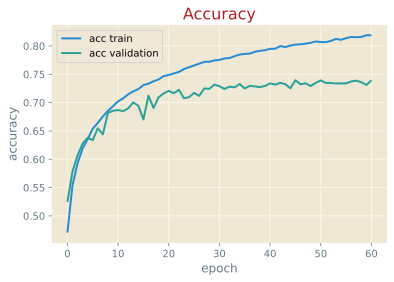

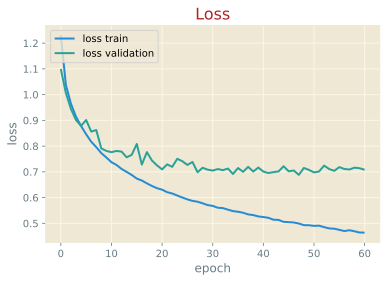

In [755]:
plot_history(history_cnn1d)

## Save

#### Save Scaler

In [ ]:
scaler.fit(data)

import joblib
joblib.dump(scaler, 'scaler_filename.joblib')


scaler = joblib.load('scaler_filename.joblib')
transformed_data = scaler.transform(new_data)

#### Save sklearn models

In [142]:
import joblib

def save_sklearn_model(model, save_dir='proto/models/', name='dummy'):
    joblib.dump(model, save_dir + f'model_{name}.joblib')

In [143]:
knn_summary_attrs = ['n_neighbors', 'radius', 'algorithm', 'leaf_size', 'metric', 'metric_params', 
                     'p', 'weights', 'n_features_in_', 'effective_metric_params_', 'effective_metric_', 
                     '_fit_method', 'n_samples_fit_']
knn_summary = {attr: KNN_model.__dict__[attr] for attr in knn_summary_attrs}

In [201]:
model_KNN.name = 'dummy_KNN'
model_KNN.accents_dict = accents_dict
# model_KNN.summary = knn_summary

In [202]:
save_sklearn_model(model_KNN, name='dummy_KNN')